# DPhi - NLP Bootcamp Datathon - Sarcasm Detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
df = pd.read_csv("Train_Dataset.csv")
df

,headline,is_sarcastic
0,supreme court votes 7-2 to legalize all worldl...,1
1,hungover man horrified to learn he made dozens...,1
2,emily's list founder: women are the 'problem s...,0
3,send your kids back to school with confidence,0
4,watch: experts talk pesticides and health,0
...,...,...
44257,greece seeks to reassure europe as tensions rise,0
44258,vatican says transgender man cannot become a g...,0
44259,protesters ejected from donald trump rally aft...,0
44260,italian recipes that are oldies but goodies,0


C:\Users\heman\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

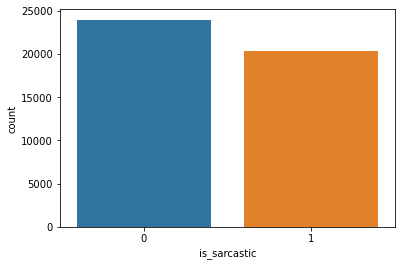

In [6]:
sns.countplot(df['is_sarcastic'])

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

train_df = pd.read_csv("Train_Dataset.csv")
X = train_df["headline"]

Y = train_df["is_sarcastic"]

X_train, X_test ,Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(39835,)
(39835,)
(4427,)
(4427,)


In [5]:
# from keras.utils import to_categorical

# Y_train_cat = to_categorical(Y_train)
# Y_test_cat = to_categorical(Y_test)

# print(Y_train_cat.shape)
# print(Y_test_cat.shape)

In [8]:
# TL Model
import keras
from keras.models import Sequential
from keras.layers import Dropout, Dense


model = Sequential()

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed_size=512
trainable = True
hub_layer = hub.KerasLayer(module_url, input_shape=[], output_shape=[embed_size], dtype=tf.string, trainable=trainable)

model.add(hub_layer)
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
# model.add(Dense(128, activation="relu"))
# model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), 
                  loss=tf.losses.BinaryCrossentropy(),
                  metrics=[tf.metrics.BinaryAccuracy(name="accuracy")])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                16416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 257,076,929
Trainable params: 257,076,929
Non-trainable params: 0
__________________________________________

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_v2.hdf5',save_best_only=True, monitor='val_loss',verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [1]:
epochs=10
batch_size=128

model.fit(X_train, Y_train,
          epochs=epochs, 
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          verbose=1,
          callbacks=callback_list)

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                  loss=tf.losses.BinaryCrossentropy(),
                  metrics=[tf.metrics.BinaryAccuracy(name="accuracy")])

In [19]:
epochs=4
batch_size=128

model.fit(X, Y,
          epochs=epochs, 
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          verbose=1,
          callbacks=callback_list)

Epoch 1/4
346/346 [==============================] - 36s 97ms/step - loss: 0.0261 - accuracy: 0.9938 - val_loss: 0.1508 - val_accuracy: 0.9614

Epoch 00001: val_loss improved from 0.16583 to 0.15078, saving model to best_v2.hdf5
Epoch 2/4
346/346 [==============================] - 33s 96ms/step - loss: 0.0230 - accuracy: 0.9945 - val_loss: 0.1356 - val_accuracy: 0.9648

Epoch 00002: val_loss improved from 0.15078 to 0.13563, saving model to best_v2.hdf5
Epoch 3/4
346/346 [==============================] - 33s 96ms/step - loss: 0.0217 - accuracy: 0.9949 - val_loss: 0.1223 - val_accuracy: 0.9677

Epoch 00003: val_loss improved from 0.13563 to 0.12231, saving model to best_v2.hdf5
Epoch 4/4
346/346 [==============================] - 33s 96ms/step - loss: 0.0195 - accuracy: 0.9955 - val_loss: 0.1118 - val_accuracy: 0.9695

Epoch 00004: val_loss improved from 0.12231 to 0.11179, saving model to best_v2.hdf5


In [13]:
model.load_weights("best_v2.hdf5")

In [20]:
model.evaluate(X_test, Y_test)

139/139 [==============================] - 1s 8ms/step - loss: 0.1118 - accuracy: 0.9695


[0.1117948666214943, 0.9695053100585938]

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(X_test)

In [26]:
preds_new = predictions>0.45

print(classification_report(Y_test, preds_new))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2428
           1       0.97      0.97      0.97      1999

    accuracy                           0.97      4427
   macro avg       0.97      0.97      0.97      4427
weighted avg       0.97      0.97      0.97      4427



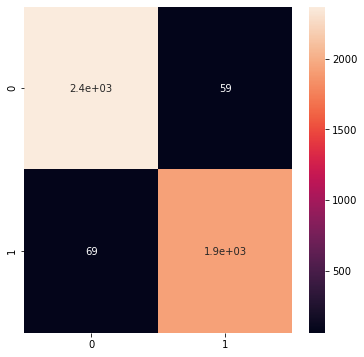

In [27]:
plt.figure(figsize=(6,6))
mat = confusion_matrix(Y_test, preds_new)
sns.heatmap(mat, annot=True)
plt.show()

In [31]:
sub_df = pd.read_csv("Test_Dataset.csv")

X_sub = sub_df["headline"]
Y_sub = model.predict(X_sub)
Y_sub = np.int64(Y_sub>0.45)

In [32]:
Y_sub = Y_sub.reshape(-1,)

In [33]:
Y_sub

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

In [34]:
submission = pd.DataFrame()
submission["prediction"] = Y_sub
submission.to_csv("hem_v5.csv", index=False)